# Линейный интерполяционный сплайн 10

### Импорт библиотек

In [1]:
import sympy as sym  # библиотека символьных вычислений
import numpy as np # библиотека для работы с массивами
import math  # для операции факториала, числа pi
import matplotlib.pyplot as plt  # для построения графиков
import pandas as pd  # для построения таблицы
from IPython.display import display  # для вывода таблицы

### Инициализация символьных переменных

In [2]:
x = sym.symbols('x')  # инициализировали символьные переменные
f = sym.Function('f')(x)  # инициализировали символьную функцию
# N = 1 - номер в списке группы
f = x - sym.sin(x) - 0.25  # определили функцию соответственно номеру в списке группы
a = 0
b = 10  # [a,b] - выбранный интервал интерполирования 

### Определим функцию решения СЛАУ методом Гаусса
#### понадобится ниже
(взято из работ прошлого семестра)

In [3]:
def Gauss(A, b): # A - матрица (n,n), b - вектор (n,1)
    n=len(b)
    #прямой ход метода Гаусса
    for k in range(n): # строки
        # поиск максимума по столбцу
        max_index=0 # индекс максимума к-го столбца
        maxk=0  # максимум к-го столбца
        for i in range(k, n): # столбцы
            if (maxk<abs(A[i][k])):
                    max_index=i
                    maxk=abs(A[i][k])
        #нашли индекс максимума, теперь меняем строки
        Cb=b[k]
        b[k]=b[max_index]
        b[max_index]=Cb
        
        C=A[k]
        A[k]=A[max_index]
        A[max_index]=C  

        # нормируем строку
        b[k]=b[k]/A[k][k]
        A[k]=[A[k][x]/A[k][k] for x in range(n)] 
        # преобразуем последующие n-k строк
        for m in range(k+1, n):
            b[m]=b[m]-b[k]*A[m][k]
            A[m]=[A[m][x]-A[k][x]*A[m][k] for x in range(n)]            
        
    #print('A=', np.array(A).round(4))
    #print('b=', np.array(b).round(4))
    
    # обратный ход метода Гаусса
    X=[0]*n # вектор неизвестных
    i=n
    while (i!=0):
        i-=1
        X[i]=b[i]
        for j in range(n-i-1):
            X[i]=X[i]-A[i][n-1-j]*X[i+1]
    return X

# Сплайн S_10
## На равноотстоящих узлах

функция возвращает вектор a=(a_11,a_10,a_21,a_20,...,a_n-1.1,a_n0)

In [4]:
def S_10(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)  
    A = []  # размерность будет 2n-2
    y = []
    X = []  # Х - вектор подматриц 2х2 матрицы А, для удобства решения СЛАУ потом
    for i in range(n-1):
        row1 = np.zeros(2*n-2)  # 1-я, 3-я и т.д. строки матрицы А
        row1[2*i] = knots[i]  # 1-й, 3-й и т.д. элемент строки
        row1[2*i+1] = 1  # 2-й, 4-й и т.д. элемент строки
        A.append(row1)  # присоединили строку
        
        row2 = np.zeros(2*n-2)  # 2-я, 4-я и т.д. строки матрицы А
        row2[2*i] = knots[i+1]
        row2[2*i+1] = 1
        A.append(row2)
        # строим вектор у
        y.append(f.subs(x, knots[i]))
        y.append(f.subs(x, knots[i+1]))
        # присоединим подматрицу 2х2 к вектору Х
        X.append([[knots[i], 1], [knots[i+1], 1]])
    # print('A=')
    # print(np.matrix(A))
    # print('y=', y)
    
    ans = []  # сюда запишем вектор a=(a_11,a_10,a_21,a_20,...,a_n-1.1,a_n0)
    for i in range(n-1):
        X1 = X[i]
        Y = [y[2*i], y[2*i+1]]
        ans.append(Gauss(X1, Y))
    ans = sum(ans, [])
    
    # print(ans)
    return ans

## Функция поиска максимума отклонения
### на равноостоящих узлах

In [5]:
def RS(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)  
    ans = S_10(n, f)  # сплайн 1,0, вектор коэффициентов
    m = 10*n  # количество точек разбиений
    r = []  # массив максимумов отклонений сплайна на отрезках [x_j,x_j+1]
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[2*j]*x + ans[2*j+1]  # полином на j-м отрезке 
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # отклонение на j-м отрезке
        r.append(max(rj))  # присоединили максимальный на отрезке
    return max(r)

## Сплайн на оптимальных узлах

все аналогично, поменяла только узлы интерполирования

In [6]:
def S_10opt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()  # отсортировала,чтобы узлы шли последовательно
    A = []  # размерность будет 2n-2
    y = []
    X = []  # Х - вектор подматриц 2х2 матрицы А, для удобства решения СЛАУ потом
    for i in range(n-1):
        row1 = np.zeros(2*n-2)  # 1-я, 3-я и т.д. строки матрицы А
        row1[2*i] = knots[i]  # 1-й, 3-й и т.д. элемент строки
        row1[2*i+1] = 1  # 2-й, 4-й и т.д. элемент строки
        A.append(row1)  # присоединили строку
        
        row2 = np.zeros(2*n-2)  # 2-я, 4-я и т.д. строки матрицы А
        row2[2*i] = knots[i+1]
        row2[2*i+1] = 1
        A.append(row2)
        # строим вектор у
        y.append(f.subs(x, knots[i]))
        y.append(f.subs(x, knots[i+1]))
        # присоединим подматрицу 2х2 к вектору Х
        X.append([[knots[i], 1], [knots[i+1], 1]])
    # print('A=')
    # print(np.matrix(A))
    # print('y=', y)
    
    ans = []  # сюда запишем вектор a=(a_11,a_10,a_21,a_20,...,a_n-1.1,a_n0)
    for i in range(n-1):
        X1 = X[i]
        Y = [y[2*i], y[2*i+1]]
        ans.append(Gauss(X1, Y))
    ans = sum(ans, [])
    
    # print(ans)
    return ans

### Функция поиска максимума отклонения на оптимальных узлах

In [7]:
def RSopt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()
    ans = S_10opt(n, f)  # сплайн 1,0, вектор коэффициентов
    m = 10*n  # количество точек разбиений
    r = []  # массив максимумов отклонений сплайна на отрезках [x_j,x_j+1]
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[2*j]*x + ans[2*j+1]  # полином на j-м отрезке 
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # присоединили максимальный на отрезке
        r.append(max(rj))
    return max(r)

# Построение таблицы

In [8]:
df = pd.DataFrame({'n': [], 'm':[], 'RS10n': [], 'RS10optn':[]})  # для построения таблицы поведения S10 при увеличении количества узлов интерполирования
n_knots = [4, 6, 9, 15, 30, 50]
for n in n_knots:
    RS10= RS(n, f)  # максимум отклонения на равноостоящих узлах
    RS10opt = RSopt(n,f)  # максимум отклонения на оптимальных узлах
    line = {'n': n, 'm': 10*n, 'RS10n':RS10, 'RS10optn':RS10opt}
    df = df.append(line, ignore_index=True)
display(df)

,n,m,RS10n,RS10optn
0,4.0,40.0,1.09143574874183,0.424401811361756
1,6.0,60.0,0.441861786049397,0.384081485890563
2,9.0,90.0,0.182284065016564,0.279082378711418
3,15.0,150.0,0.0629487066728638,0.112936302157330
4,30.0,300.0,0.0148236686314399,0.0317951448822473
5,50.0,500.0,0.00520160269281611,0.0117142126326186


# Построение графиков
## на равноотстоящих узлах

In [9]:
# для удобства определим функцию построения графика
def plot_spline(n, a, b, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)  
    for i in range(n-1):
        X = np.arange(knots[i], knots[i+1], 0.05)
        ans = S_10(n,f)
        li = ans[2*i]*x + ans[2*i+1]   # l_i = a_i1*x+a_i0
        lix = [li.subs(x, xk) for xk in X]  # подставили точки хк
        plt.plot(X, lix, '--', linewidth = 3)

Text(0.5, 1.0, 'График №1 S_10 n=3, n=10, n=50')

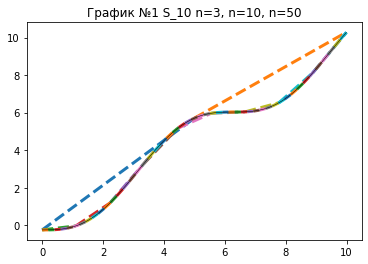

In [10]:
plt.figure()
x = sym.symbols('x')
li = sym.Function('li')(x)
ab = np.arange(a, b, 0.01)
fx = [f.subs(x, xi) for xi in ab]
plot_spline(3, 0, 10, f)
plot_spline(10, 0, 10, f)
plot_spline(50, 0, 10, f)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plt.title('График №1 S_10 n=3, n=10, n=50')

### Для наглядности так же в таком варианте 

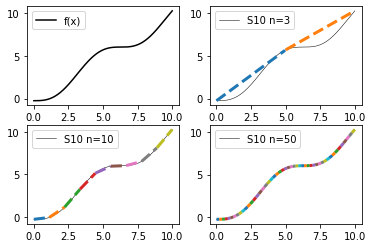

In [11]:
plt.figure(3)
plt.subplot(221)
plt.plot(ab, fx, 'k')
label = ['f(x)']
plt.legend(label)
plt.subplot(222)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(3, 0, 10, f)
label = ['S10 n=3']
plt.legend(label)
plt.subplot(223)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(10, 0, 10, f)
label = ['S10 n=10']
plt.legend(label)
plt.subplot(224)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(50, 0, 10, f)
label = ['S10 n=50']
plt.legend(label)

## на оптимальных узлах

In [12]:
# для удобства определим функцию построения графика
def plot_spline_opt(n, a, b, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()
    for i in range(n-1):
        X = np.arange(knots[i], knots[i+1], 0.05)
        ans = S_10opt(n,f)
        li = ans[2*i]*x + ans[2*i+1]  # l_i = a_i1*x+a_i0
        lix = [li.subs(x, xk) for xk in X]
        plt.plot(X, lix, '--', linewidth = 3)

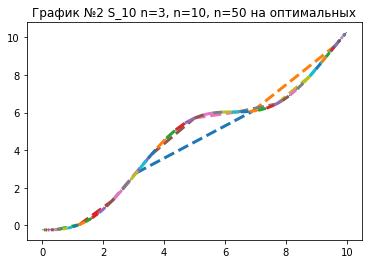

In [13]:
plt.figure(4)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plt.title('График №2 S_10 n=3, n=10, n=50 на оптимальных')
plot_spline_opt(3, 0, 10, f)
plot_spline_opt(10, 0, 10, f)
plot_spline_opt(50, 0, 10, f)

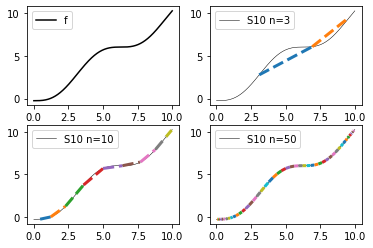

In [14]:
plt.figure(3)
plt.subplot(221)
plt.plot(ab, fx, 'k')
plt.legend('f(x)')
plt.subplot(222)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(3, 0, 10, f)
label = ['S10 n=3']
plt.legend(label)
plt.subplot(223)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(10, 0, 10, f)
label = ['S10 n=10']
plt.legend(label)
plt.subplot(224)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(50, 0, 10, f)
label = ['S10 n=50']
plt.legend(label)